In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import seaborn as sns

from unpast.core.preprocessing import zscore
from unpast.misc.eval import calculate_perfromance
from unpast.misc.ds_synthetic_builder import ScenarioBiclusters  # , build_dataset
from unpast.run_unpast import unpast
from unpast.utils.io import read_bic_table, write_bic_table
from unpast.utils.visualization import plot_heatmap

%matplotlib inline

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:170: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert outfile_basename is "", "Output directory must be not specified."


# Simulated expression data

* 10000 features x 200 samples
* background ~Norm(0,1), bicluster ~ Norm(4,1)
* four biclusters with fraction [0.05,0.1,0.25,0.5] of all columns (samples) simulate four subtypes

* Complexity:
    - Simple: n=500 features per bicluster 
    - Features: n=5 features per bicluster 
* Scenarios:
    - A: biclusters do not overlap
    - B: random overlaps in samples
    - C: random overlaps in samples + co-expression modules in the background
    
    
* co-expression modules of user-defined size with avg. Pearson r about 0.5 added to the background


In [2]:
seed = 42
output_folder = Path("test_data_sim/")


# dimensions of the matrix  (genes, samples)
size = (10000, 200)
common_args = {
    "seed": seed,
    # bicluster expression parameters
    "m": 4,
    "std": 1,
    # fractions of samples included to each subtype
    "frac_samples": [0.05, 0.1, 0.25, 0.5],
}

# Generate four test datasets:

(5,500) x (A,C)

## number of features in each bicluster (i.e. biomarkers) 
* 5, 50, or 500 features in each bicluster 

## Scenario A
* non-overlapping feature and sample clusters 
* background contains no signal

## Scenario B
* same as A, but with overlapping sample clusters 
* (not tested)

## Scenario C 
* overlapping sample clusters, non-overlapping in features 
* four 500-feature co-expression modules added to the background

*! only 2000 background genes are shown in the figures

In [3]:
# number of biomarkers, i.e. features in biclusters
n_features_per_bic = [5, 50, 500]

# scenarios
scenarios = ["A", "C"]

# parameters for scenarios A and C
scenario_args = {
    "A": {"add_coexpressed": [], "g_overlap": False, "s_overlap": False},
    "B": {"add_coexpressed": [], "g_overlap": False, "s_overlap": True},
    "C": {
        "add_coexpressed": [500]
        * 4,  # add 4 co-expression modules of 500 genes each, with avg. r=0.5
        "g_overlap": False,
        "s_overlap": True,
    },
}

Building data for A_5


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:189: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


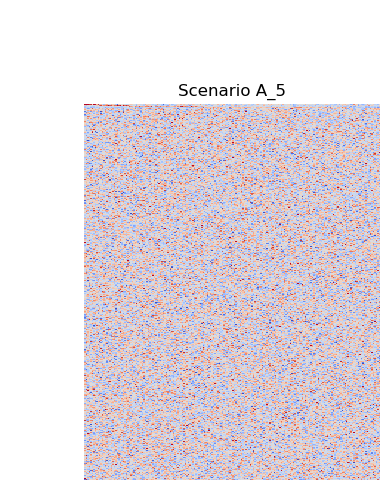

Building data for C_5


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:189: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


	co-exprs. module 500 features, avg. pairwise r=0.52
	co-exprs. module 500 features, avg. pairwise r=0.48
	co-exprs. module 500 features, avg. pairwise r=0.57
	co-exprs. module 500 features, avg. pairwise r=0.41


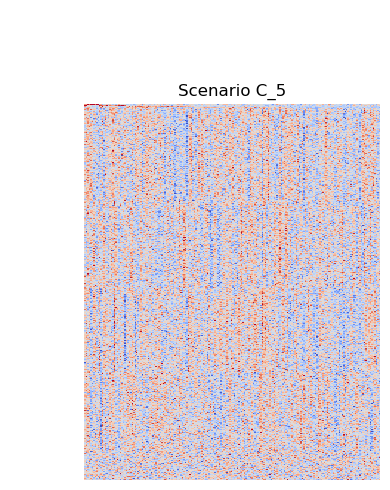

Building data for A_50


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:189: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


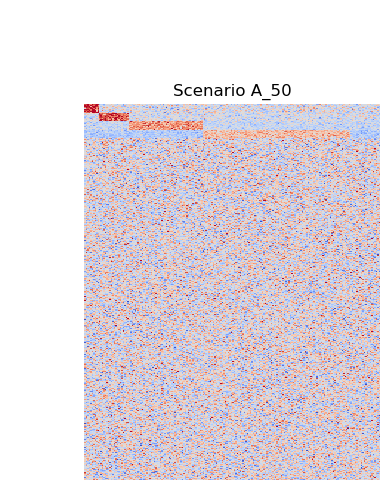

Building data for C_50


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:189: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


	co-exprs. module 500 features, avg. pairwise r=0.47
	co-exprs. module 500 features, avg. pairwise r=0.46
	co-exprs. module 500 features, avg. pairwise r=0.53
	co-exprs. module 500 features, avg. pairwise r=0.51


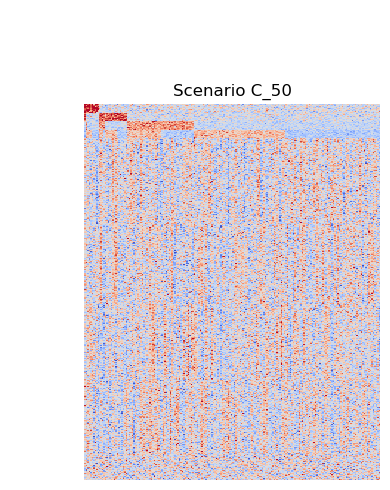

Building data for A_500


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:189: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


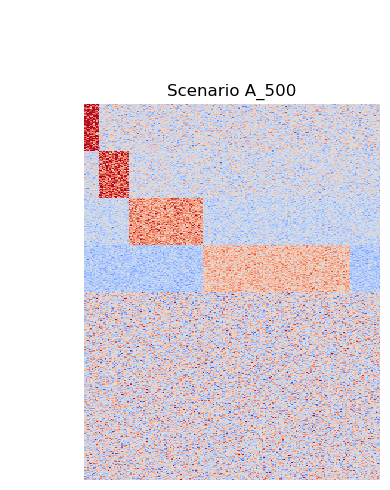

Building data for C_500


/Users/savmac/proj/Biclustering/unpast/notebooks/../unpast/misc/ds_synthetic_builder.py:189: UserWarning: seed None currently ignored
  warnings.warn(f"seed {seed} currently ignored")


	co-exprs. module 500 features, avg. pairwise r=0.51
	co-exprs. module 500 features, avg. pairwise r=0.49
	co-exprs. module 500 features, avg. pairwise r=0.56
	co-exprs. module 500 features, avg. pairwise r=0.51


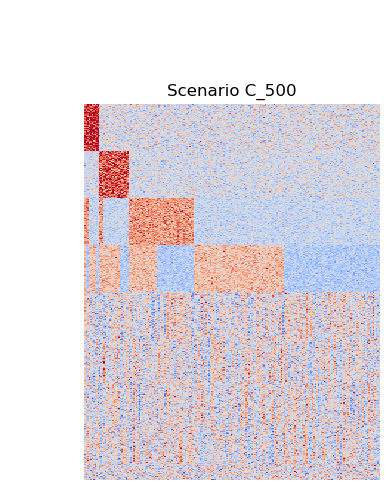

In [4]:
for n_biomarkers in n_features_per_bic:
    for sc_name in scenarios:
        scenario = f"{sc_name}_{n_biomarkers}"
        print(f"Building data for {scenario}")

        # generate input data and ground truth
        # and save to files <outdir>/<outfile_basename>*
        data, ground_truth, extra = ScenarioBiclusters(
            size,
            g_size=n_biomarkers,
            **common_args,
            **scenario_args[sc_name],
        ).build(None)
        coexpressed_modules = extra["coexpressed_modules"]

        # save
        (output_folder / scenario).mkdir(parents=True, exist_ok=True)
        exprs_file = output_folder / scenario / "data.tsv"
        bicluster_file = output_folder / scenario / "biclusters.tsv"
        data.to_csv(exprs_file, sep="\t")
        write_bic_table(ground_truth, str(bicluster_file))

        # plot heatmaps
        plot_heatmap(
            data,
            ground_truth,
            coexpressed_modules=coexpressed_modules,
            fig_title="Scenario " + scenario,
            fig_path=output_folder / "img" / f"Fig_{scenario}.png",
            limit_features=4 * n_biomarkers + 2000,  # don't show too much background
        )
        # plt.show()
        # save ground truth as bicluster file

# UnPaSt Evaluation

(example - С_500)

* run unpast with a fixed seed
* clust_method="Louvain" - to avoid problems with R

In [6]:
data_folder = str(output_folder) + "/"

# input file name
scenario = "A_5"
data_file = data_folder + scenario + "" + ".data.tsv.gz"
print(data_file)
pd.read_csv(data_file, sep="\t", index_col=0).head(3)

test_data_sim/A_5.data.tsv.gz


,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_190,s_191,s_192,s_193,s_194,s_195,s_196,s_197,s_198,s_199
g_0,0.577318,-0.104719,0.739481,1.679693,-0.207714,-0.207696,1.740040,0.868101,-0.460474,0.626561,...,-0.435813,0.963658,0.273753,-1.294267,0.229808,0.457665,-0.905567,0.208910,0.106315,-1.183883
g_1,0.275500,0.481170,1.010313,0.980679,-1.482808,-1.037173,0.434818,0.433552,0.434831,3.816463,...,-0.997243,0.411398,-1.424616,1.768575,1.107971,-0.562352,-1.822691,1.284700,-0.203047,1.167116
g_2,-1.517816,-0.516799,0.091444,0.133431,-0.366595,0.712752,-0.987851,-0.057064,0.207185,0.603691,...,0.158164,-0.394352,0.568019,0.421830,1.129927,-0.426905,-0.185324,-0.898462,-0.360788,0.465730


In [7]:
# read ground truth biclusters from files
biclusters_file_name = data_folder + scenario + ".true_biclusters.tsv.gz"
true_biclusters = read_bic_table(biclusters_file_name)
print(biclusters_file_name)
true_biclusters

test_data_sim/A_5.true_biclusters.tsv.gz


,genes,samples,frac,n_genes,n_samples,sample_indexes,gene_indexes,genes_up,genes_down,SNR
id,,,,,,,,,,
bic_0.05,"{g_7730, g_4187, g_4754, g_1837, g_9921}","{s_66, s_159, s_171, s_82, s_134, s_57, s_143,...",0.05,5,10,"{66, 165, 134, 171, 143, 17, 82, 87, 57, 159}","{9921, 1837, 7730, 4754, 4187}","{g_7730, g_4187, g_4754, g_1837, g_9921}",{},4.023803
bic_0.1,"{g_3476, g_4380, g_8752, g_8312, g_9690}","{s_49, s_130, s_11, s_113, s_106, s_26, s_73, ...",0.10,5,20,"{0, 130, 5, 9, 11, 150, 26, 161, 168, 170, 49,...","{8752, 3476, 8312, 9690, 4380}","{g_3476, g_4380, g_8752, g_8312, g_9690}",{},3.632381
bic_0.25,"{g_4059, g_5023, g_9041, g_176, g_8214}","{s_14, s_95, s_29, s_101, s_123, s_65, s_94, s...",0.25,5,50,"{128, 129, 2, 132, 6, 137, 141, 142, 14, 144, ...","{176, 9041, 8214, 4059, 5023}","{g_4059, g_5023, g_9041, g_176, g_8214}",{},3.570585
bic_0.5,"{g_2890, g_2838, g_2096, g_9486, g_5846}","{s_8, s_118, s_100, s_74, s_23, s_102, s_18, s...",0.50,5,100,"{1, 4, 7, 8, 10, 12, 15, 16, 18, 19, 21, 22, 2...","{2890, 9486, 2096, 5846, 2838}","{g_2890, g_2838, g_2096, g_9486, g_5846}",{},3.726347


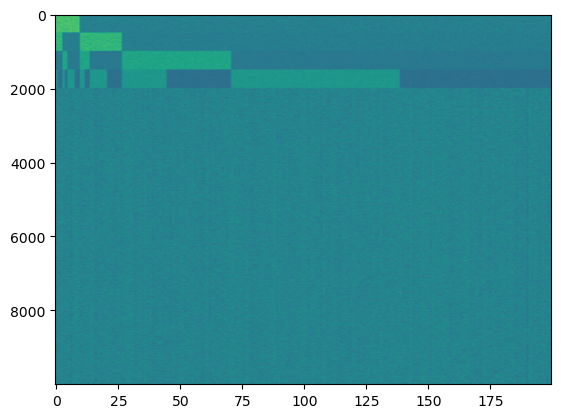

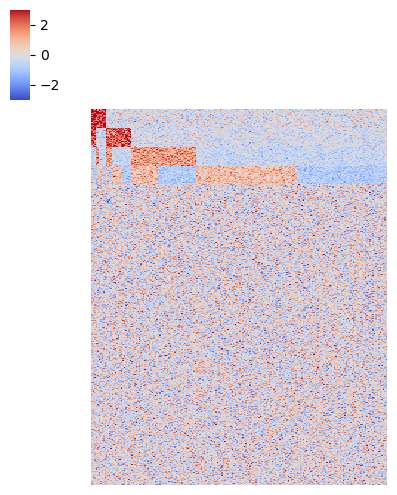

In [ ]:
def draw_mat_simple(exprs, bics):
    genes_in_bics = {
        gene: [gene in bic for bic in bics["genes"].values] for gene in exprs.index
    }
    genes_sorted = sorted(
        exprs.index, key=lambda item: genes_in_bics[item], reverse=True
    )

    samples_in_bics = {
        sample: [sample in bic for bic in bics["samples"].values]
        for sample in exprs.columns
    }
    # samples_sorted = sorted(exprs.columns, key=lambda item: [not x for x in samples_in_bics[item]], reverse=True)
    samples_sorted = sorted(
        exprs.columns, key=lambda item: samples_in_bics[item], reverse=True
    )

    plt.imshow(exprs.loc[genes_sorted, samples_sorted], aspect="auto")
    plt.show()

    sns.clustermap(
        zscore(exprs.loc[genes_sorted, samples_sorted]),
        xticklabels=False,
        yticklabels=False,
        row_cluster=False,
        col_cluster=False,
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        vmin=-3,
        vmax=3,
        figsize=(4, 5),
    )


draw_mat_simple(data, ground_truth)

In [43]:
bics["genes"].values

array([{'g_5431', 'g_9875', 'g_9410', 'g_9519', 'g_9543', 'g_2572', 'g_497', 'g_8517', 'g_1951', 'g_9563', 'g_1848', 'g_4997', 'g_8978', 'g_2879', 'g_9933', 'g_2378', 'g_2861', 'g_3806', 'g_2369', 'g_4221', 'g_9232', 'g_729', 'g_7721', 'g_5331', 'g_4862', 'g_1603', 'g_9242', 'g_4344', 'g_7695', 'g_1012', 'g_3690', 'g_6746', 'g_5460', 'g_3249', 'g_2756', 'g_8080', 'g_3748', 'g_4609', 'g_1221', 'g_8980', 'g_9146', 'g_6029', 'g_6987', 'g_3131', 'g_6229', 'g_6834', 'g_332', 'g_141', 'g_2081', 'g_4650', 'g_1705', 'g_4157', 'g_3339', 'g_2700', 'g_6910', 'g_61', 'g_2290', 'g_1722', 'g_3188', 'g_6243', 'g_9478', 'g_194', 'g_7832', 'g_2674', 'g_8469', 'g_8834', 'g_1753', 'g_7612', 'g_3650', 'g_5838', 'g_5553', 'g_8138', 'g_6533', 'g_6080', 'g_7151', 'g_7735', 'g_2889', 'g_2129', 'g_5272', 'g_3270', 'g_1526', 'g_2393', 'g_9153', 'g_1345', 'g_6586', 'g_473', 'g_9663', 'g_3893', 'g_7137', 'g_9758', 'g_2272', 'g_850', 'g_2429', 'g_1303', 'g_9675', 'g_640', 'g_237', 'g_737', 'g_8537', 'g_2829', 'g_3

In [27]:
genes_sorted

[('g_0', [False, False, False, False, False, False, False, False, False]),
 ('g_1', [False, False, False, False, False, False, False, False, False]),
 ('g_2', [False, False, False, False, False, False, False, False, False]),
 ('g_3', [False, False, False, False, False, False, False, False, False]),
 ('g_4', [False, False, False, False, False, False, False, False, False]),
 ('g_5', [False, False, False, False, False, False, False, False, False]),
 ('g_6', [False, False, False, False, False, False, False, False, False]),
 ('g_7', [False, False, False, False, False, False, False, False, False]),
 ('g_8', [False, False, False, False, False, False, False, False, False]),
 ('g_9', [False, False, False, False, False, False, False, False, False]),
 ('g_10', [False, False, False, False, False, False, False, False, False]),
 ('g_11', [False, False, False, False, False, False, False, False, False]),
 ('g_12', [False, False, False, False, False, False, False, False, False]),
 ('g_13', [False, Fals

## Performance measures 
* Feature and sample set evaluation:
    * wARIs - sum of sample ARIs of all matched biclusters weighted by their prevalence
    * F1_f_avg, F1_s_avg -  F1 for features/samples of best matching biclusters, averaged across four biclusters
    
* For all biclusters:
    * FDR_bics  - FDR = FP/(TP+FP) - fraction of wrongly biclustered elements in among all predicted biclusters  
    * Recall_bics - Recall = TP/P - fractoion of correctly biclustered elements in among all true bicluster

In [8]:
def add_performance_cols(
    best_matches_, true_biclusters, pred_biclusters, target="genes", all_samples=None
):
    best_matches = best_matches_.loc[:, :].copy()

    best_matches.loc[best_matches["bm_id"].dropna().index, "pred_" + target] = (
        best_matches["bm_id"].dropna().apply(lambda x: pred_biclusters.loc[x, target])
    )
    best_matches.loc[:, "pred_" + target] = best_matches.loc[
        :, "pred_" + target
    ].fillna("")
    best_matches.loc[best_matches["pred_" + target] == "", "pred_" + target] = (
        best_matches.loc[best_matches["pred_" + target] == "", "pred_" + target].apply(
            lambda x: set([])
        )
    )

    if target == "samples":
        best_matches.loc[best_matches["is_enriched"] == False, "pred_" + target] = (
            best_matches.loc[
                best_matches["is_enriched"] == False, "pred_" + target
            ].apply(lambda x: all_samples.difference(x))
        )
    best_matches["bic_id"] = best_matches.index
    best_matches["true_" + target] = best_matches["bic_id"].apply(
        lambda x: true_biclusters.loc[x, target]
    )

    best_matches["TP_" + target] = best_matches.apply(
        lambda row: row["true_" + target].intersection(row["pred_" + target]), axis=1
    )
    # true positive rate == Recall
    best_matches["TPR_" + target] = best_matches.apply(
        lambda row: len(row["TP_" + target]) / len(row["true_" + target]), axis=1
    )

    # precision
    best_matches["Prec_" + target] = 0.0
    non_zero = best_matches["pred_" + target].apply(len) > 0
    best_matches.loc[non_zero, "Prec_" + target] = best_matches.loc[non_zero, :].apply(
        lambda row: len(row["TP_" + target]) / len(row["pred_" + target]), axis=1
    )

    # keep only biclusters matching anything
    best_matches["F1_" + target] = 0.0
    mbic_ids = best_matches["Prec_" + target] + best_matches["TPR_" + target]
    mbic_ids = mbic_ids[mbic_ids > 0].index.values

    prec = best_matches.loc[mbic_ids, "Prec_" + target] * 1.0
    rec = best_matches.loc[mbic_ids, "TPR_" + target] * 1.0
    pr = prec + rec
    best_matches.loc[mbic_ids, "F1_" + target] = 2.0 * np.multiply(prec, rec) / pr

    return best_matches


def calc_performance_measures(best_matches_, true_biclusters, pred_biclusters, exprs):
    best_matches = add_performance_cols(
        best_matches_,
        true_biclusters,
        pred_biclusters,
        target="samples",
        all_samples=set(exprs.columns.values),
    )

    best_matches = add_performance_cols(
        best_matches, true_biclusters, pred_biclusters, target="genes"
    )

    F1_f_avg = best_matches["F1_genes"].sum() / true_biclusters.shape[0]
    F1_s_avg = best_matches["F1_samples"].sum() / true_biclusters.shape[0]

    # FP in matched biclusters
    # number of elements in matched biclusters not in true biclusters
    df = best_matches
    pred_P_matched = df["pred_genes"].apply(len) * df["pred_samples"].apply(len)
    TP = df["TP_genes"].apply(len) * df["TP_samples"].apply(len)
    FP1 = pred_P_matched - TP

    #  number of elements in non-matched biclusters
    bm_ids = list(set(best_matches["bm_id"].values))
    not_mbic_ids = [x for x in pred_biclusters.index if not x in bm_ids]
    df2 = pred_biclusters.loc[not_mbic_ids, :]
    FP2 = df2["n_genes"] * df2["n_samples"]

    FP = FP2.sum() + FP1.sum()

    # ratio of predicted bicluster elements (FP) not matching true biclusters, to all biclusters predicted elements (TP+FP)
    P = true_biclusters["n_genes"] * true_biclusters["n_samples"]
    P = P.sum()
    # FDR
    FDR_bic = FP / (TP.sum() + FP)

    # Recall
    Recall_bic = TP.sum() / P

    return best_matches, F1_f_avg, F1_s_avg, FDR_bic, Recall_bic

# Run unpast for all test scenarios

In [9]:
for n_biomarkers in n_features_per_bic:
    for sc_name in scenarios:
        scenario = sc_name + "_" + str(n_biomarkers)
        print(scenario)
        # input file name
        data_file = data_folder + scenario + "" + ".data.tsv.gz"

        ### run unpast ###
        print("running unpast for %s" % data_file)
        out_dir = data_folder + f"/unpast_runs/run_{scenario}.predicted"

        # predicted biclusters
        pred_biclusters = unpast(
            data_file,
            out_dir=out_dir,
            clust_method="Louvain",
            seed=seed,
            verbose=False,
        )
        print("%s biclusters detected:%s" % (scenario, pred_biclusters.shape[0]))
        biclusters_file_name = out_dir + scenario + ".pred_biclusters.tsv.gz"
        print("saving to %s" % biclusters_file_name)
        write_bic_table(pred_biclusters, biclusters_file_name)

A_5
running unpast for test_data_sim/A_5.data.tsv.gz


sknetwork version used: 0.33.0
sknetwork version used: 0.33.0


A_5 biclusters detected:9
saving to test_data_sim//unpast_results/A_5.pred_biclusters.tsv.gz
C_5
running unpast for test_data_sim/C_5.data.tsv.gz


sknetwork version used: 0.33.0
sknetwork version used: 0.33.0


C_5 biclusters detected:19
saving to test_data_sim//unpast_results/C_5.pred_biclusters.tsv.gz
A_50
running unpast for test_data_sim/A_50.data.tsv.gz


sknetwork version used: 0.33.0
sknetwork version used: 0.33.0


A_50 biclusters detected:10
saving to test_data_sim//unpast_results/A_50.pred_biclusters.tsv.gz
C_50
running unpast for test_data_sim/C_50.data.tsv.gz


sknetwork version used: 0.33.0
sknetwork version used: 0.33.0


C_50 biclusters detected:7
saving to test_data_sim//unpast_results/C_50.pred_biclusters.tsv.gz
A_500
running unpast for test_data_sim/A_500.data.tsv.gz


sknetwork version used: 0.33.0
sknetwork version used: 0.33.0


A_500 biclusters detected:7
saving to test_data_sim//unpast_results/A_500.pred_biclusters.tsv.gz
C_500
running unpast for test_data_sim/C_500.data.tsv.gz


sknetwork version used: 0.33.0
sknetwork version used: 0.33.0


C_500 biclusters detected:11
saving to test_data_sim//unpast_results/C_500.pred_biclusters.tsv.gz


# Evaluate all pre-computed biclusters 

In [10]:
performances = {}
suffix = ".bin=kmeans,pval=0.01,clust=Louvain,direction=DOWN-UP,m=0.33.biclusters.tsv"
suffix = ".seed=" + str(42) + suffix

for n_biomarkers in n_features_per_bic:
    for sc_name in scenarios:
        scenario = sc_name + "_" + str(n_biomarkers)
        print(scenario)

        # read pre-computed (predicted) biclusters
        basename = scenario + ".predicted"
        predicted_dir = data_folder + f"/unpast_runs/run_{scenario}.predicted"
        pred_biclusters = read_bic_table(predicted_dir + "/biclusters.tsv")

        print(scenario, "found biclusters: %s" % pred_biclusters.shape[0])

        # read data
        data_file = data_folder + scenario + "" + ".data.tsv.gz"
        print("use data file from %s" % data_file)
        data = pd.read_csv(data_file, sep="\t", index_col=0)
        # true biclusters

        # read ground truth biclusters from files
        biclusters_file_name = data_folder + scenario + ".true_biclusters.tsv.gz"
        true_biclusters = read_bic_table(biclusters_file_name)
        print(biclusters_file_name)

        # Finding best matches and estimating performance
        all_samples = set(data.columns.values)  # all samples in the dataset
        known_groups = true_biclusters.loc[:, ["samples"]].to_dict()["samples"]
        known_groups = {
            "true_biclusters": known_groups
        }  # can be more than one classification => it is a dict of dicts

        res, best_matches = calculate_perfromance(
            pred_biclusters, known_groups, all_samples, performance_measure="ARI"
        )
        # sum of per-bicluster ARIs, weighted proporionally to the bicluster frequency
        wARIs = res["true_biclusters"]
        best_matches, F1_f_avg, F1_s_avg, FDR_bic, Recall_bic = (
            calc_performance_measures(
                best_matches.dropna(), true_biclusters, pred_biclusters, data
            )
        )
        performances[scenario] = {
            "wARIs": wARIs,
            "F1_f_avg": F1_f_avg,
            "F1_s_avg": F1_s_avg,
            "FDR_bic": FDR_bic,
            "Recall_bic": Recall_bic,
        }
performances = pd.DataFrame.from_dict(performances).T
performances.to_csv("performances.tsv", sep="\t")
performances

A_5
A_5 found biclusters: 9
use data file from test_data_sim/A_5.data.tsv.gz
test_data_sim/A_5.true_biclusters.tsv.gz
C_5
C_5 found biclusters: 19
use data file from test_data_sim/C_5.data.tsv.gz
test_data_sim/C_5.true_biclusters.tsv.gz
A_50
A_50 found biclusters: 10
use data file from test_data_sim/A_50.data.tsv.gz
test_data_sim/A_50.true_biclusters.tsv.gz
C_50
C_50 found biclusters: 7
use data file from test_data_sim/C_50.data.tsv.gz
test_data_sim/C_50.true_biclusters.tsv.gz
A_500
A_500 found biclusters: 7
use data file from test_data_sim/A_500.data.tsv.gz
test_data_sim/A_500.true_biclusters.tsv.gz
C_500
C_500 found biclusters: 11
use data file from test_data_sim/C_500.data.tsv.gz
test_data_sim/C_500.true_biclusters.tsv.gz


,wARIs,F1_f_avg,F1_s_avg,FDR_bic,Recall_bic
A_5,0.838087,0.500000,0.628788,0.790034,0.833333
C_5,0.822222,0.500000,0.498744,0.870345,0.827778
A_50,0.944947,0.580808,0.795455,0.471393,0.850000
C_50,0.944444,0.588599,0.750000,0.519231,0.866667
A_500,1.000000,0.620297,1.000000,0.010042,0.863111
C_500,0.944444,0.514914,0.750000,0.028590,0.740333


In [ ]:
thresholds = pd.DataFrame(
    {
        "A_5": [0.8, 0.5, 0.6, 0.75, 0.8],
        "C_5": [0.8, 0.4, 0.45, 0.85, 0.8],
        "A_50": [0.9, 0.5, 0.7, 0.4, 0.8],
        "C_50": [0.9, 0.5, 0.7, 0.5, 0.8],
        "A_500": [0.9, 0.6, 0.7, 0.01, 0.85],
        "C_500": [0.9, 0.5, 0.7, 0.02, 0.7],
    },
    index=["wARIs", "F1_f_avg", "F1_s_avg", "FDR_bic", "Recall_bic"],
).T
quality_check = performances >= thresholds
display(quality_check)

assert quality_check.all().all()